# Four Guys DSGP 

## Question
How to automatically switch notification mode on mobile phone by using sensory data collected from smartphone and smartwatch？

## Data Source
http://extrasensory.ucsd.edu

Publicly available: everyone is invited to download the dataset for free and use it (conditioned on citing our original paper).

## Data Preprocessing

### Functions

In [1]:
import numpy as np
import gzip
import pandas as pd
from sklearn.impute import KNNImputer 
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

#### parse_header_of_csv

This method take a dataframe as input, return the feature part and label part

In [2]:
def parse_header_of_csv(csv_df):
    # Isolate the headline columns:

    for (ci,col) in enumerate(csv_df.columns):
        # find the start of label column
            if col.startswith('label:'):
                first_label_ind = ci
                break
            pass
    # use the "start of label" find above to split feature and label
    feature_names = csv_df.columns[1:first_label_ind]
    label_names = list(csv_df.columns[first_label_ind:-1])

    # remove "label: " get pure label name
    for (li,label) in enumerate(label_names):
    # In the CSV the label names appear with prefix 'label:', but we don't need it after reading the data:
            assert label.startswith('label:')
            label_names[li] = label.replace('label:','')
            pass

    csv_df.rename(columns=dict(zip(csv_df.columns[first_label_ind:-1],label_names)),inplace=True)
        
    return (feature_names,label_names)

#### parse_body_of_csv

This method take a dataframe and number of features as input, return sensor matrix, label matrix, missing label matrix and timestamp matrix(index)

In [3]:
def parse_body_of_csv(csv_df,n_features):


    # Read the entire CSV body into a single numeric matrix:
    
    # Timestamp is the primary key for the records (examples):
    timestamps = csv_df.index
    # Read the sensor features:
    X = csv_df[csv_df.columns[0:n_features+1]]
    # Read the binary label values, and the 'missing label' indicators:
    trinary_labels_mat = csv_df[csv_df.columns[n_features+1:-1]] # This should have values of either 0., 1. or NaN

    M = pd.isna(trinary_labels_mat) # M is the missing label matrix
    Y = np.where(M,0,trinary_labels_mat) > 0. # Y is the label matrix

    
    return (X,Y,M,timestamps)

#### read_user_data

Read the data (precomputed sensor-features and labels) for a user.

This function assumes the user's data file is present.

this method take id of subject as input
return sensor matrix, label matrix, missing label matrix and timestamp matrix(index) by calling parse_body_of_csv()method

In [4]:
def read_user_data(uuid):
    user_data_file = 'Datasets/%s.features_labels.csv.gz' % uuid

    with gzip.open(user_data_file,'rb') as fid:
        csv_df = pd.read_csv(fid,delimiter=',', index_col= 0)
        pass

    (feature_names,label_names) = parse_header_of_csv(csv_df)
    n_features = len(feature_names)
    (X,Y,M,timestamps) = parse_body_of_csv(csv_df,n_features)

    return (X,Y,M,timestamps,feature_names,label_names)

#### get_df_list

by calling this method we can get a list of dataframe which contain all the user's sensor data

3.6 v0 may get label lists later w.

Author chen

In [5]:
def get_df_list():
    #To create uuid_list which includes all uuid
    uuid_list = []
    f = open('UUID List.txt', 'r')
    for line in f.readlines():
        uuid_list.append(line.strip())

    main_feature = []
    f = open('Main Feature.txt', 'r')
    for line in f.readlines():
        main_feature.append(line.strip())

    instance = []
    # Run all uuid
    for i in range(len(uuid_list)):    
        (X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid_list[i])

        # Create dataframe for all Main Feature value
        Main_X = pd.DataFrame(X.loc[:,X.columns.str.startswith(main_feature[0])], columns = [main_feature[0]])
        for j in range(1,len(main_feature)):
            Main_X = pd.concat([Main_X, X.loc[:,X.columns.str.startswith(main_feature[j])]], axis=1)
        instance.append(Main_X)
    return instance

#### get_df

For getting single user data to dataframe.

In [6]:
def get_df(uuid):
    main_feature = []
    f = open('Main Feature.txt', 'r')
    for line in f.readlines():
        main_feature.append(line.strip())

    # Run all uuid 
    (X,Y,M,timestamps,feature_names,label_names) = read_user_data(uuid)

    # Create dataframe for all Main Feature value
    Main_X = pd.DataFrame(X.loc[:,X.columns.str.startswith(main_feature[0])], columns = [main_feature[0]])
    for j in range(1,len(main_feature)):
        Main_X = pd.concat([Main_X, X.loc[:,X.columns.str.startswith(main_feature[j])]], axis=1)
    return Main_X

#### data_imputer

by calling these two methods we can fill the null values of feature data.
1. $non\_ watch\_ value\_ imputer$ is use the mean value to fill the feature data from sensors except watch sensors.
2. $KNN\_ for \_ watch \_ data$ is use K nearest neighour to fill the feature data from watch.

In [7]:
def non_watch_value_imputer(df):
    # get the data except watch
    non_watch_values = df.loc[:,(df.columns.str.startswith('watch_') == False)]
    valid_data = pd.DataFrame(columns = ['blank'])
    # use mean values to fill the none value
    for column in non_watch_values.columns:
        column_df = non_watch_values[column]
        mean_value = non_watch_values[column].mean()
        column_df = column_df.fillna(mean_value)
        valid_data = pd.concat([valid_data, column_df],axis=1,ignore_index=False)

    valid_data = valid_data[valid_data.columns[1:]]
    #combine the watch data
    combine_data = pd.concat([valid_data,df.loc[:,df.columns.str.startswith('watch_')]],axis=1,ignore_index=False)
    return combine_data

def KNN_for_watch_data(df,K):
    #input data and K neighbors
    imputer = KNNImputer(n_neighbors=K)
    df[list(df.columns)] = imputer.fit_transform(df)
    return df 

#### pca_to_train_test

by calling this function, PCA can be applied to the pre-cleaned and splitted data.

return the processed data and pca components.

In [8]:
def pca_to_data(csv_df,n):

    pca = PCA(n_components=n)
    features = csv_df.loc[:,csv_df.columns.str.startswith('audio_naive')]
    new_features = pca.fit_transform(features)
    pca_components = pca.components_

    print('PCA explained variance ratio is', pca.explained_variance_ratio_.sum())

    new_feature_df = pd.DataFrame(data=new_features,index=csv_df.index,columns=['audio_naive:pc1','audio_naive:pc2'])
    other_features = csv_df.loc[:,(csv_df.columns.str.startswith('audio_naive') == False)]
    new_feature_df = pd.concat([other_features,new_feature_df],axis=1,ignore_index=False)


    return (new_feature_df, pca_components)

def pca_to_train_test(X_train, X_test, data):
    
    X_train = pd.DataFrame(X_train,columns=data.iloc[:,:-1].columns)
    X_test = pd.DataFrame(X_test,columns=data.iloc[:,:-1].columns)
    X_train_pca, projection = pca_to_data(X_train,2)

    audio_test = X_test.loc[:,X_test.columns.str.startswith('audio_naive')]
    X_test_pca = X_test.loc[:,X_test.columns.str.startswith('audio_naive')==False]
    projection_matrix = pd.DataFrame(np.dot(audio_test,projection.T),columns=['audio_naive:pc1','audio_naive:pc2'])
    X_test_pca = pd.concat([X_test_pca,projection_matrix],axis=1)
    return X_train_pca.values, X_test_pca.values

#### get_related_label

by calling this function, input wanted label 

return counts of this label (For EDA)

In [9]:
def get_related_label(char):
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    new_label_data = []
    for uuid in data.groupby('uuid').count().index:
        X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid)
        label_dict = {v: k for k, v in dict(enumerate(label_names + ['None'])).items()}
        label_list = []
        for each in Y:
            if np.array(each).any()==False:
                continue
            else:
                new_label_names = np.array(label_names)[each]
                if char in new_label_names:
                    label_list.append(list(new_label_names))
    new_label_data = new_label_data + label_list
    labels = []
    for i in new_label_data:
        labels = labels + i
    l_dict = {}
    for key in labels:
        l_dict[key] = l_dict.get(key, 0) + 1
    return l_dict


#### splitdata

Input:<br>
Final_data: dataframe<br>
test_size: split ratio for testing dataset and validation dataset<br>

Output:<br>
x_train, y_train, x_val, y_val, x_test, y_test<br>

This function will extract the input ratio data from every user's dataset as the testing dataset and validation dataset. The remaining data will be used as the training dataset. These datasets will be used for non-time series models.

In [10]:
def splitdata(Final_data,test_size):
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    idlist = data.groupby('uuid').count().index
    
    stamps_index = {}
    for id in idlist:
        length = len(Final_data.loc[id])
        random.seed(777)
        stamps_index[id] = random.sample(range(0,length),int(length*test_size))

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for k, v in stamps_index.items():
        # Select testing data
        test_data = pd.concat([test_data, Final_data.loc[k].iloc[v]], axis = 0)
        
        # Remove testing data from original dataset
        total = Final_data.loc[k]
        remain = total[~total.isin(Final_data.loc[k].iloc[v])].dropna()
        
        # Remaining data are training data
        train_data = pd.concat([train_data, remain], axis = 0)
        
        # Shuffle training and testing data
        from sklearn.utils import shuffle
        test_data = shuffle(test_data)
    
        # Prepare testing data X and Y
        x_test = test_data.iloc[:,:-1].values
        y_test = test_data.iloc[:,-1].values.astype(int)

        # Prepare training data X and Y
        train_data_x = train_data.iloc[:,:-1].values
        train_data_y = train_data.iloc[:,-1].values.astype(int)
        
        # Split training and validation dataset
        from sklearn.model_selection import train_test_split
        x_train, x_val, y_train, y_val = train_test_split(train_data_x, train_data_y, test_size=0.15, shuffle=True)
    

    return x_train, y_train, x_val, y_val, x_test, y_test

#### TS_data

Input:<br>
dataset: should be np.array <br>
n_past: number of lags (timestamps back) to use for models<br>
n_pred: steps ahead to forecast<br>

Output:<br>
X, Y: 3D tuple

This function will convert the time series array into X and Y tuple for the training of time series model.<br>
The shape of X is (samples, timesteps, features).<br>
samples — total number of sequences constructed for training.<br>
timesteps — the length of the samples.<br>
features — number of features used.<br>

In [11]:
def TS_data(dataset, n_past, n_pred):
    # Counting the amount of features passed from the array 
    n_features = dataset.shape[1]
    
    X, Y = [], []

    if len(dataset) - n_past <= 0:
        X.append(dataset)
    else:
        for i in range(len(dataset) - n_past - n_pred):
            Y.append(dataset[(i + n_past):(i + n_past + n_pred), -1])
            X.append(dataset[i:(i + n_past)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], n_past, n_features))

    return X, Y

#### TS_split

Input:<br>
Final_data: dataframe <br>
n_past: number of lags (timestamps back) to use for models<br>
n_pred: steps ahead to forecast<br>

Output:<br>
x_train, y_train, x_val, y_val, x_test, y_test

This function will randomly extracted data from 38 users as the training dataset, 7 users as the validation dataset, and another 7 users as the test dataset.<br>
Then, convert the dataset into a dataset form acceptable to the recurrent neural network. Output datasets will be used for time series models.

In [12]:
def TS_split(Final_data, n_past, n_pred):
    import random
    with gzip.open('cleaned_data.zip','rb') as data:
        data = pd.read_csv(data,index_col=[0,1])
    idlist = data.groupby('uuid').count().index

    random.seed(505)
    randid = random.sample(list(range(0,len(idlist))), len(idlist))

    train_data = pd.DataFrame()
    validation_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for i in randid[0:38]:
        train_data = pd.concat([train_data, Final_data.loc[idlist[i]]], axis = 0)
        
    for i in randid[38:45]:
        validation_data = pd.concat([validation_data, Final_data.loc[idlist[i]]], axis = 0)

    for i in randid[45:]:
        test_data = pd.concat([test_data, Final_data.loc[idlist[i]]], axis = 0)
    
    
    x_train, y_train = TS_data(train_data.values, n_past, n_pred)
    
    x_val, y_val = TS_data(validation_data.values, n_past, n_pred)
    
    x_test, y_test = TS_data(test_data.values, n_past, n_pred)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

### Data cleaning


In [13]:
uuid_list = []
f = open('UUID List.txt', 'r')
for line in f.readlines():
    uuid_list.append(line.strip())
valid_data = pd.DataFrame()
for uuid in uuid_list:
    df = get_df(uuid)
    try:
        cleaned_data = non_watch_value_imputer(df)
        cleaned_data = KNN_for_watch_data(cleaned_data,10)
        muti_index = pd.MultiIndex.from_product([[uuid], cleaned_data.index], names=['uuid','timestamps'])
        cleaned_data = pd.DataFrame(cleaned_data.values, columns=cleaned_data.columns, index=muti_index)
        valid_data = pd.concat([valid_data,cleaned_data],axis=0,ignore_index=False)
    except:
        print(uuid,'failed to export')
valid_data.to_csv('cleaned_data.zip',mode = 'w',compression= 'gzip')

40E170A7-607B-4578-AF04-F021C3B0384A failed to export
61359772-D8D8-480D-B623-7C636EAD0C81 failed to export
61976C24-1C50-4355-9C49-AAE44A7D09F6 failed to export
7D9BB102-A612-4E2A-8E22-3159752F55D8 failed to export
CCAF77F0-FABB-4F2F-9E24-D56AD0C5A82F failed to export
ECECC2AB-D32F-4F90-B74C-E12A1C69BBE2 failed to export
F50235E0-DD67-4F2A-B00B-1F31ADA998B9 failed to export
FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF failed to export


### Label Replacement

In [14]:
with gzip.open('cleaned_data.zip','rb') as data:
    data = pd.read_csv(data,index_col=[0,1])
main_label_list = [['SLEEPING'],
                   ['LAB_WORK', 'IN_CLASS', 'IN_A_MEETING', 'LOC_main_workplace','COMPUTER_WORK','AT_SCHOOL', 'WITH_CO-WORKERS'],
                   ['FIX_walking', 'FIX_running', 'BICYCLING','OR_exercise'],
                   ['COOKING', 'BATHING_-_SHOWER', 'CLEANING', 'DOING_LAUNDRY', 'WASHING_DISHES', 'TOILET', 'GROOMING', 'DRESSING','EATING'],
                   ['FIX_restaurant','SHOPPING', 'STROLLING', 'DRINKING__ALCOHOL_','WATCHING_TV', 'SURFING_THE_INTERNET', 'AT_A_PARTY', 'AT_A_BAR', 'LOC_beach', 'SINGING', 'WITH_FRIENDS'],                   
                   ['IN_A_CAR', 'ON_A_BUS', 'DRIVE_-_I_M_THE_DRIVER', 'DRIVE_-_I_M_A_PASSENGER','STAIRS_-_GOING_DOWN', 'ELEVATOR']]

new_label_list = ['sleep','efficiency','exercise','life_activity','entertainment','on_the_way']
new_label_dict = {'sleep':0, 'efficiency':1, 'exercise':2, 'life_activity':3, 'entertainment':4, 'on_the_way':5, 'Normal':6}
all_label_list = []

for i in main_label_list:
    all_label_list = all_label_list + i

new_label_data = pd.DataFrame()
for uuid in data.groupby('uuid').count().index:
    X,Y,M,timestamps,feature_names,label_names = read_user_data(uuid)
    label_pair = pd.DataFrame(
        columns = ['Label Name'],
        index = timestamps
    )
    s = Y.shape


    for i in range(0,s[0]):
        arr = np.where(Y[i]==1)
        temp = []
        for j in arr[0]:
            temp.append(label_names[j])
        label_pair.loc[timestamps[i], 'Label Name'] = temp

    new_label = []
    new_index = []
    for index in label_pair.index:
        label = label_pair.loc[index].values[0]
        if bool(label) == True:
            for num,status in enumerate(main_label_list):
                if bool(set(status) & set(label)):
                    new_label.append(num)
                    new_index.append(index)
                    break
                elif bool(set(label) & set(all_label_list)):
                    continue
                else:
                    new_label.append(new_label_dict['Normal'])
                    new_index.append(index)
                    break 

    muti_index = pd.MultiIndex.from_product([[uuid], new_index], names=['uuid','timestamps'])
    new_label = pd.DataFrame(data = new_label, index = muti_index,columns = ['Status'])
    new_label_data = pd.concat([new_label_data,new_label],axis=0,ignore_index=False)

new_label_data.to_csv('new_label_data.zip',mode = 'w',compression= 'gzip')

### PCA for Audio Data
This part is using principle component analysis to reduce the dimension of audio data

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
def pca_to_data(csv_df,n):

    pca = PCA(n_components=n)
    features = csv_df.loc[:,csv_df.columns.str.startswith('audio_naive')]
    new_features = pca.fit_transform(features)
    pca_components = pca.components_
    eigenvalues = pca.explained_variance_ratio_

    print('PCA explained variance ratio is', pca.explained_variance_ratio_.sum())

    new_feature_df = pd.DataFrame(data=new_features,index=csv_df.index,columns=range(n))
    other_features = csv_df.loc[:,(csv_df.columns.str.startswith('audio_naive') == False)]
    new_feature_df = pd.concat([other_features,new_feature_df],axis=1,ignore_index=False)


    return (new_feature_df, pca_components,eigenvalues)

new_feature_df, pca_components,eigenvalues = pca_to_data(audio_data,13)
sns.set_style('whitegrid') 
plt.figure(figsize=(15,10))
g = sns.lineplot(np.cumsum(eigenvalues))
g.set_xticks(range(13))
g.set_xticklabels(['PC%s'% str(i+1) for i in range(13)])
plt.xlabel('Number of Principle Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

## EDA

In [15]:
import seaborn as sns  
sns.set_style('whitegrid') 

In [16]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

### Pie chart of labels

[76307 76282 59461 26862 21555 21197  9891]


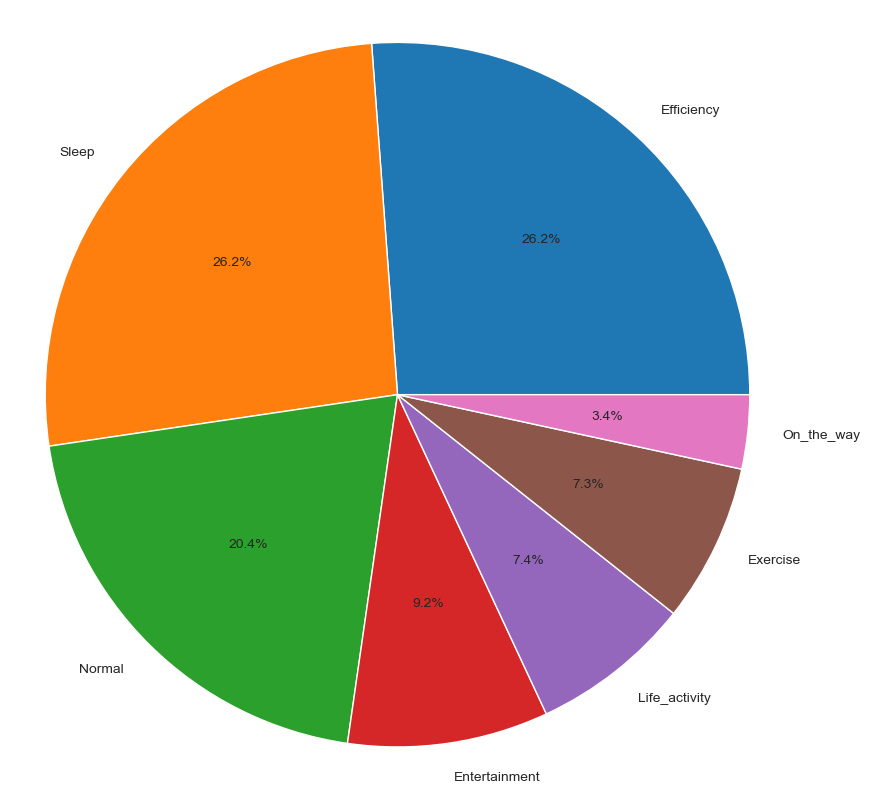

In [17]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

new_label_pair = data.iloc[:,-1].value_counts().index
new_label_count = data.iloc[:,-1].value_counts().values

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
new_label_pair = [new_label_dict.get(i) for i in new_label_pair]

print(new_label_count)
plt.figure(figsize=(10,10))
plt.pie(new_label_count,labels = new_label_pair, autopct = '%.1f%%')
plt.rcParams.update({"font.size":20})
plt.axis('equal')
plt.show()

### Data distribution & time series

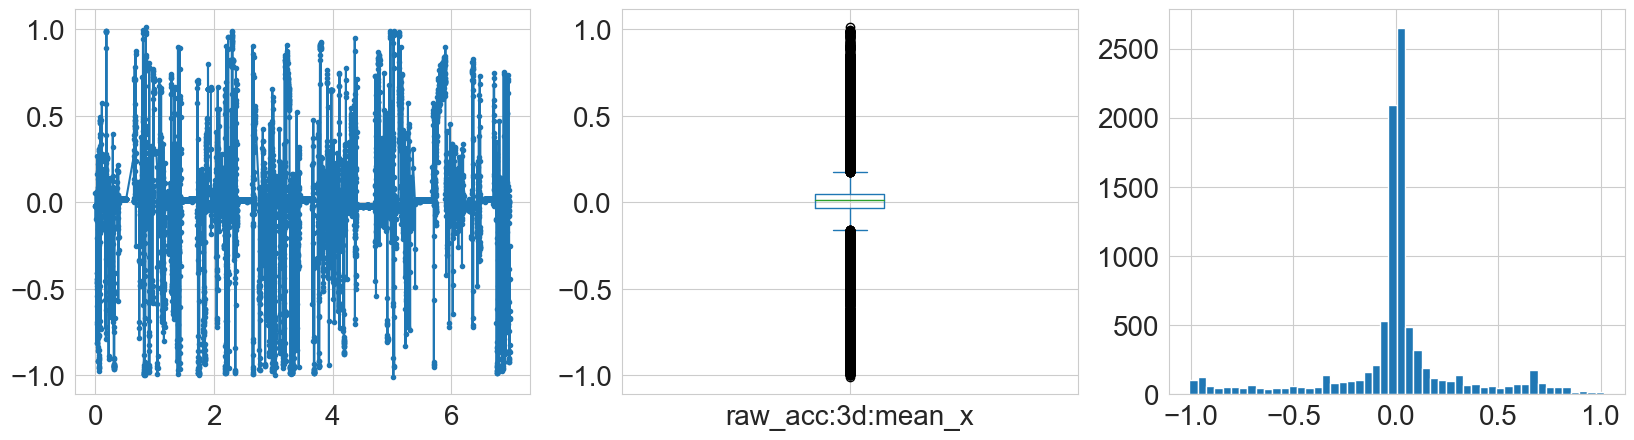

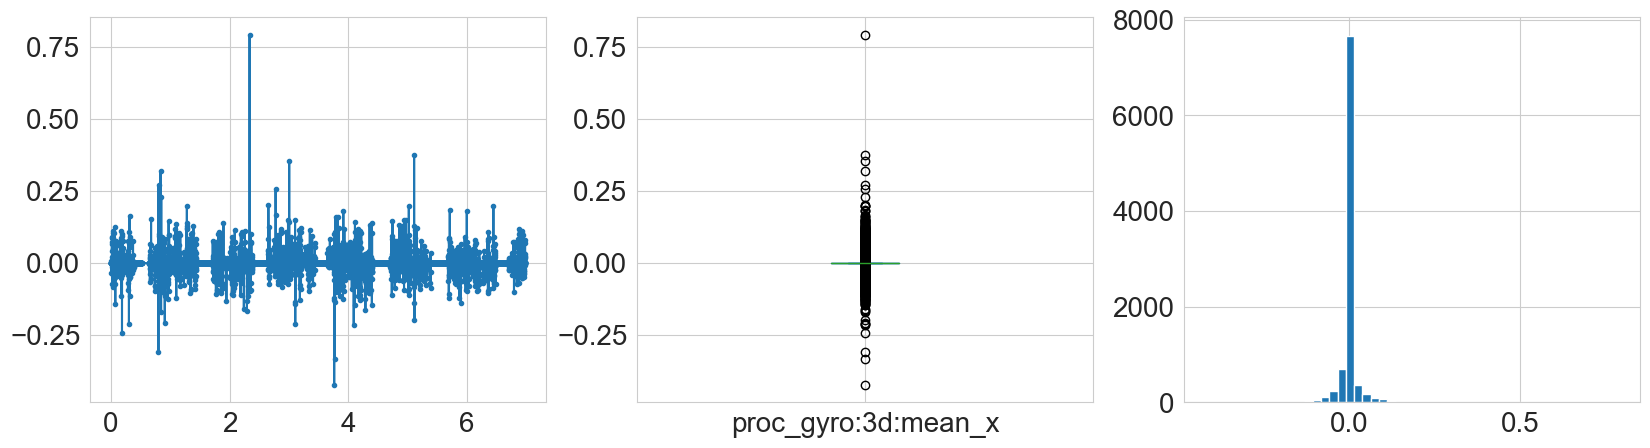

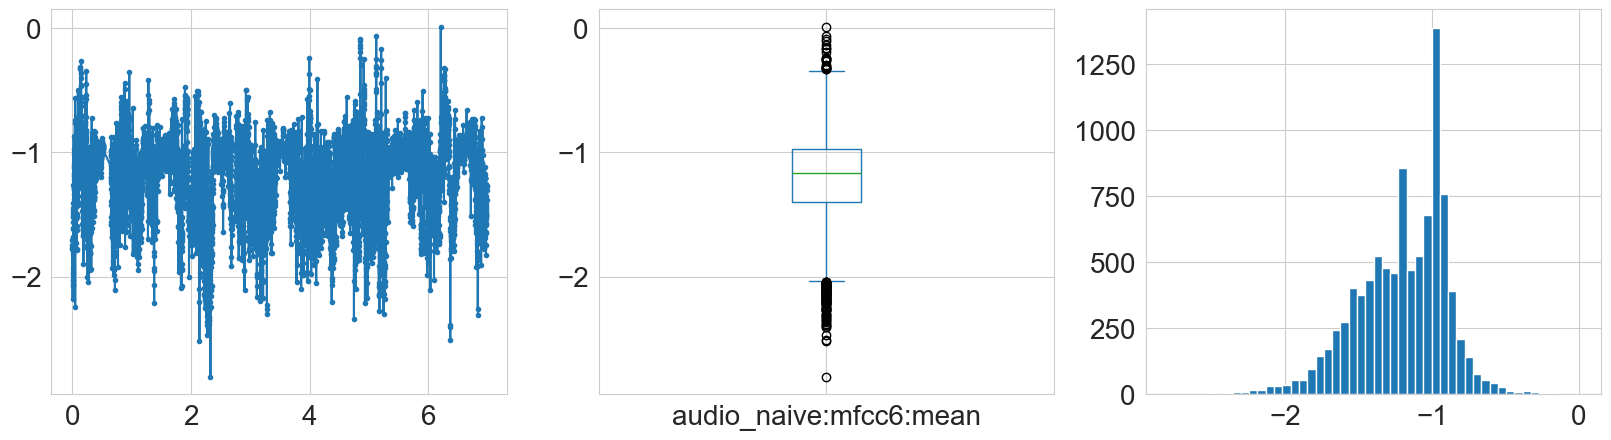

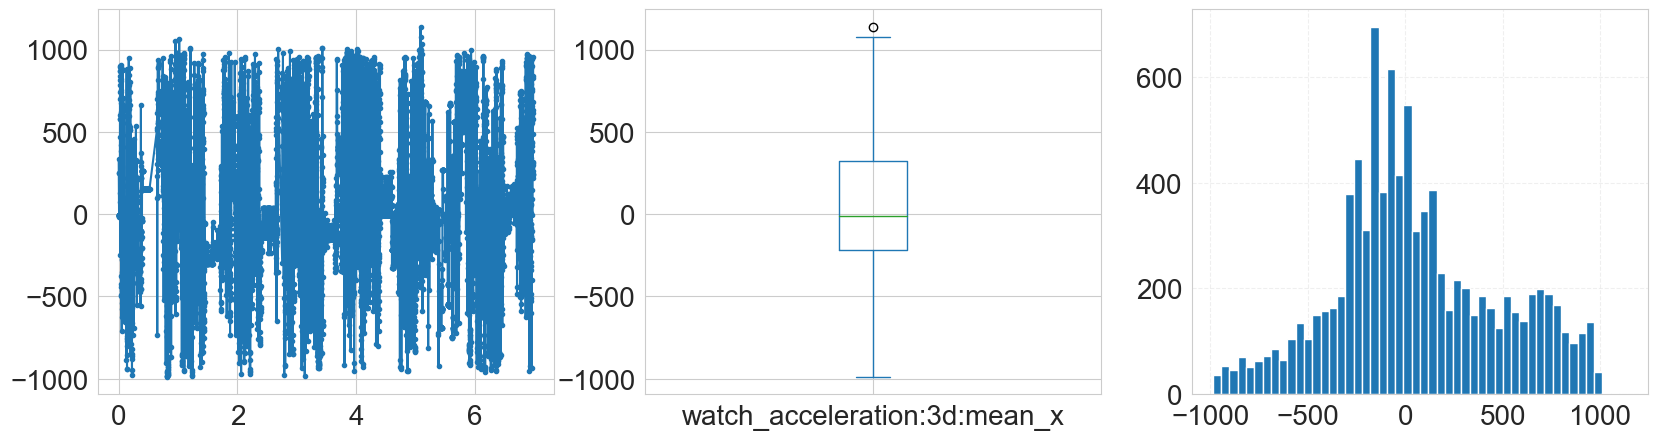

In [18]:
uuid = data.groupby('uuid').count().index[36]
timestamps = data.loc[uuid].index.values
values = data.loc[uuid].iloc[:,:-1]
daytimes = []
for time in timestamps:
    daytimes.append((time - timestamps[0])/float(60*60*24))

feature_number = len(values.columns)
feature_list = [1,5,18,47]
for i in feature_list:
    feature_value = values[values.columns[i]]
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1,3,1)
    ax1.plot(daytimes,feature_value,'.-')
    ax2 = plt.subplot(1,3,2)
    feature_value.plot.box()
    ax3 = plt.subplot(1,3,3)
    ax3.hist(feature_value,bins = 50)
plt.grid(linestyle = "--", alpha=0.3)

plt.show()
#print(values.describe())

### Relative Position data from Accelerometer

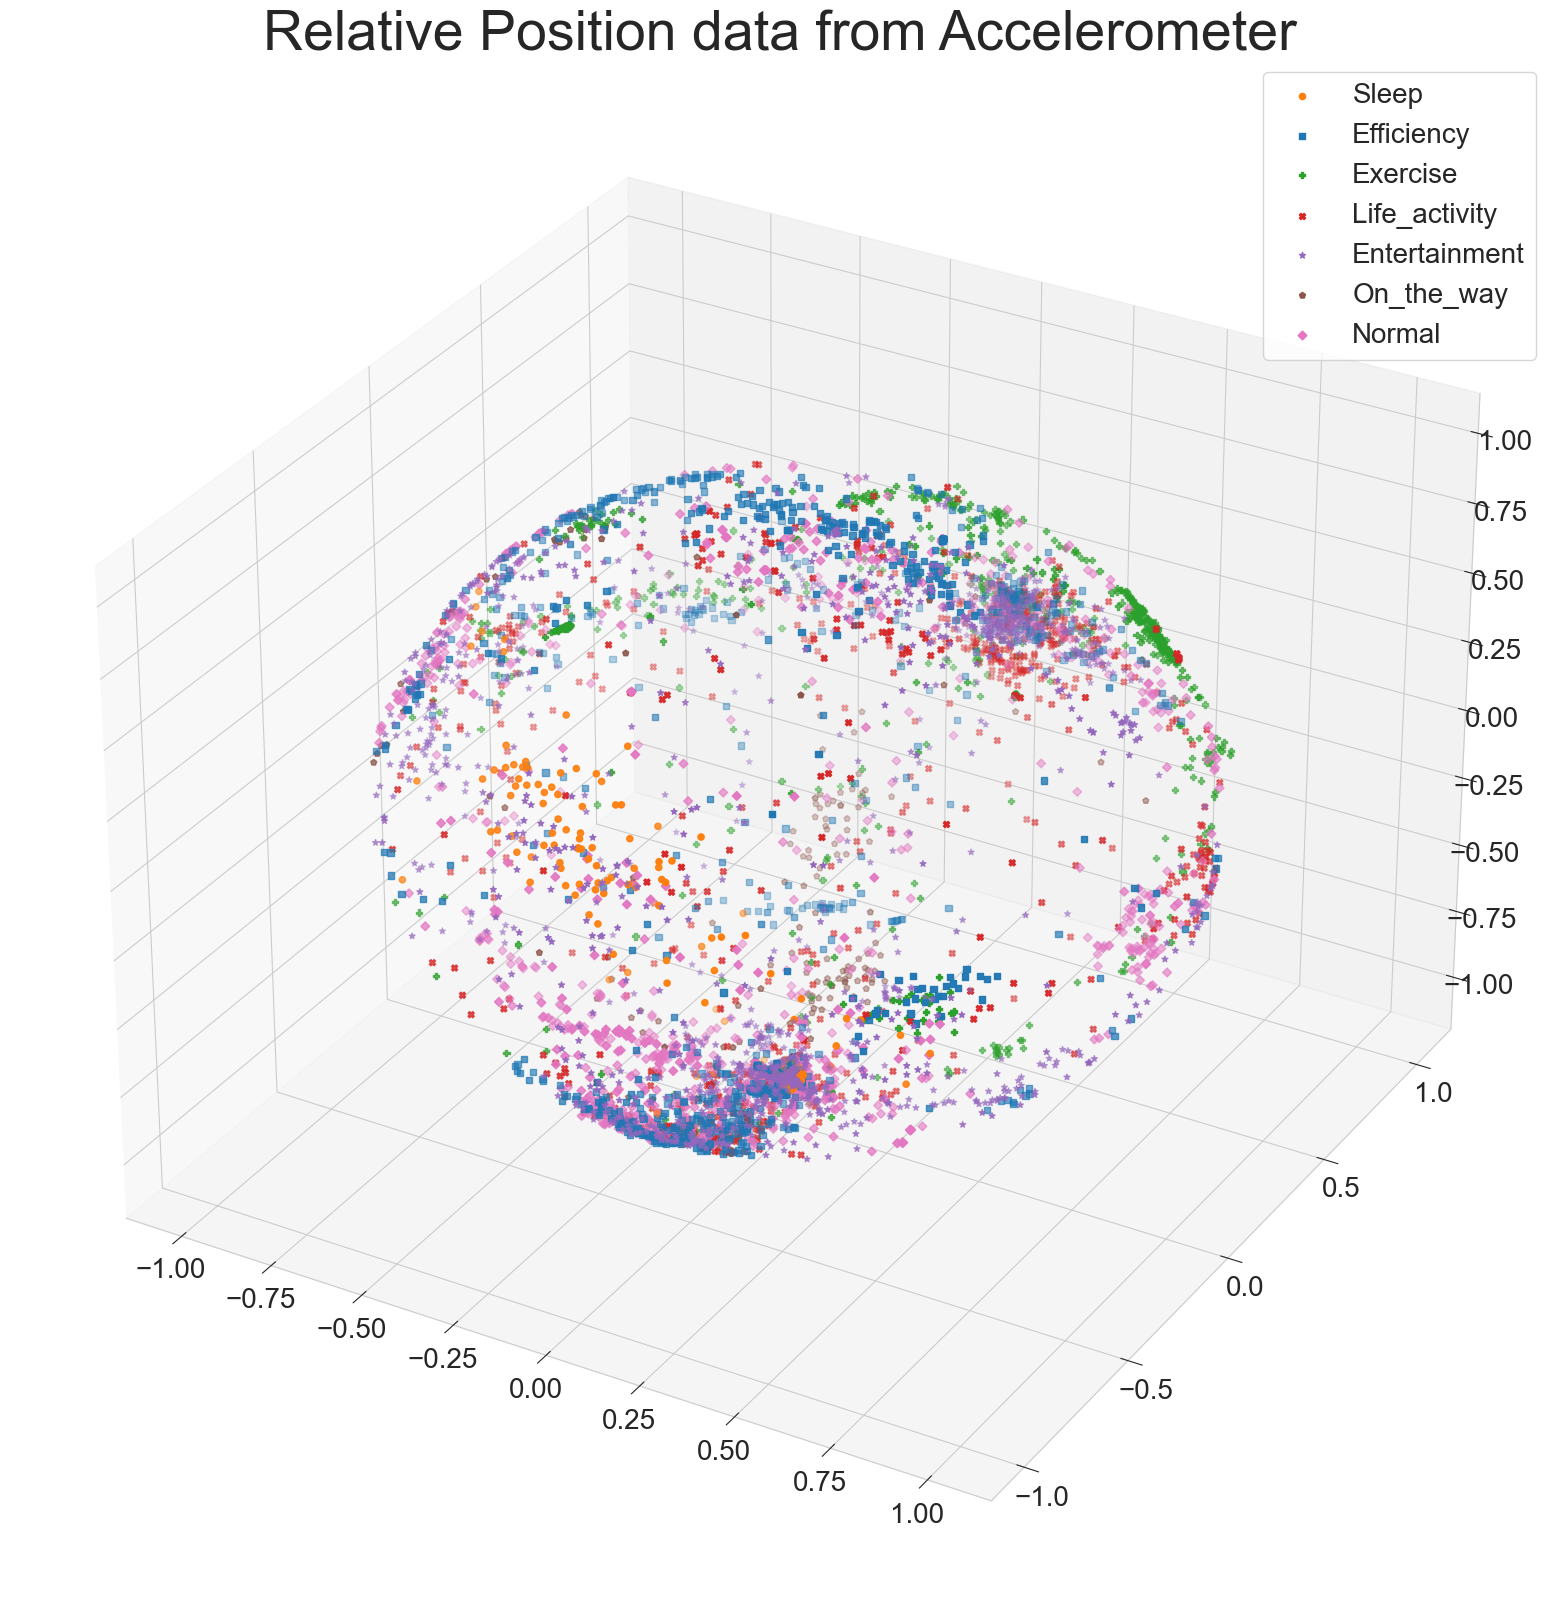

In [19]:
uuid_data = data.loc[uuid]
acc = uuid_data.iloc[:,1:4]
label = uuid_data.iloc[:,-1]
label_type = uuid_data.iloc[:,-1].value_counts().index


new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}


fig = plt.figure(figsize=(20,20))
colors = ['#ff7f0e','#1f77b4',  '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
markers = ['o','s','P','X','*','p','D']
plt.rcParams.update({"font.size":20})
fig = plt.axes(projection='3d')
for i in range(7):
    index = label[label.values == i].index
    fig.scatter(acc.loc[index].iloc[:,0],acc.loc[index].iloc[:,1],acc.loc[index].iloc[:,2],label=new_label_dict[i],marker=markers[i],c=colors[i])

plt.legend()
plt.title('Relative Position data from Accelerometer',fontsize=40)

plt.show()

### Absolute Position data from Accelerometer in 1 day

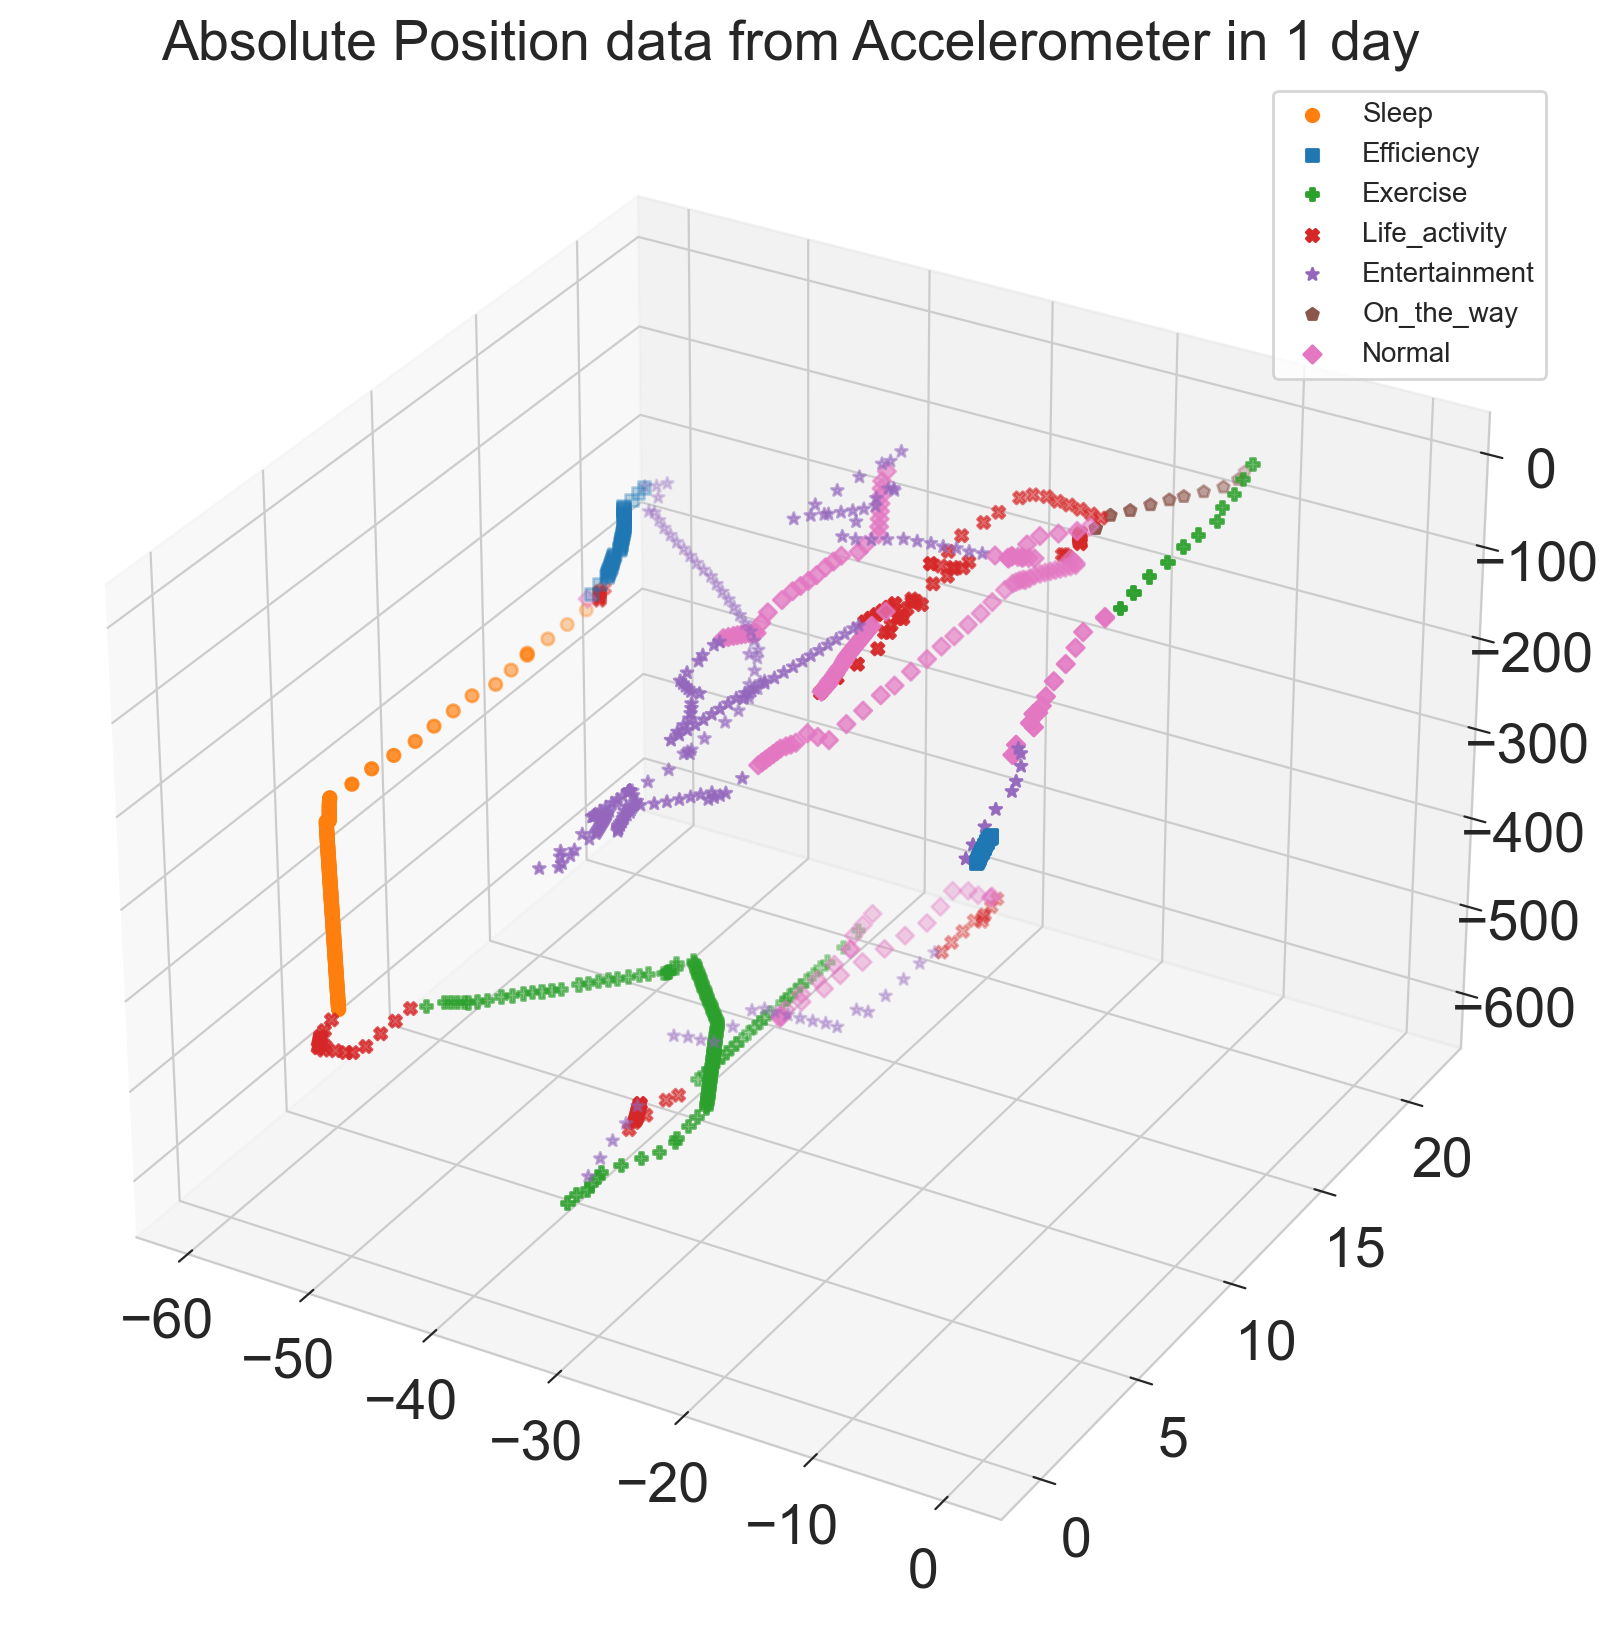

In [20]:
def get_sum_list(slice_df):
    to_list = list(slice_df)
    for i in range(len(to_list)):
        to_list[0] = 0
        to_list[i] = to_list[i-1] + to_list[i]
    return to_list

uuid_data = data.loc[uuid].iloc[:1000,:]
acc = uuid_data.iloc[:,1:4]
label = uuid_data.iloc[:,-1]
label_type = uuid_data.iloc[:,-1].value_counts().index


for i in range(3):
    acc.iloc[:,i] = get_sum_list(acc.iloc[:,i])

new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
label = uuid_data.iloc[:,-1]
label_type = uuid_data.iloc[:,-1].value_counts().index

fig = plt.figure(figsize=(10,10),dpi=200)

colors = ['#ff7f0e','#1f77b4',  '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
markers = ['o','s','P','X','*','p','D']
ax2 = plt.axes(projection='3d')
for i in range(7):
    index = label[label.values == i].index
    ax2.scatter(acc.loc[index].iloc[:,0],acc.loc[index].iloc[:,1],acc.loc[index].iloc[:,2],c = colors[i],label=new_label_dict[i],marker=markers[i])
plt.rcParams.update({"font.size":10})
plt.legend(fontsize=10)
plt.title('Absolute Position data from Accelerometer in 1 day',fontsize=20)
plt.show()

### ADF test


In [21]:
with gzip.open('cleaned_data.zip','rb')as file:
    cleaned_data = pd.read_csv(file, index_col=[0,1])

cleaned_uuid = []
for i in cleaned_data.index:
    cleaned_uuid.append(i[0])
cleaned_uuid = list(set(cleaned_uuid))

In [22]:
from statsmodels.tsa.stattools import adfuller

uuid_nan = pd.DataFrame(
  columns = cleaned_data.columns,
  index = cleaned_uuid
)

uuid_stationary = pd.DataFrame(
  columns = [x for x in cleaned_data.columns if 'discrete' not in x],
  index = cleaned_uuid
)


# Run all cleaned_uuid
for i in range(len(cleaned_uuid)):    
    temp_data = cleaned_data.loc[cleaned_uuid[i]]
    
    # Run all Main Feature
    for feature_name in cleaned_data.columns:
        # Create uuid_nan dataframe to check the number of missing values
        uuid_nan.loc[cleaned_uuid[i],feature_name] = np.isnan(temp_data[feature_name]).sum()
        
        # ADF Test without discrete feature
        if 'discrete' not in feature_name:            
            result = adfuller(temp_data[feature_name])

            # Create uuid_stationary dataframe to check stationary
            if result[1] < 0.05:
                uuid_stationary.loc[cleaned_uuid[i],feature_name] = "Stationary"
            else:
                uuid_stationary.loc[cleaned_uuid[i],feature_name] = "False"

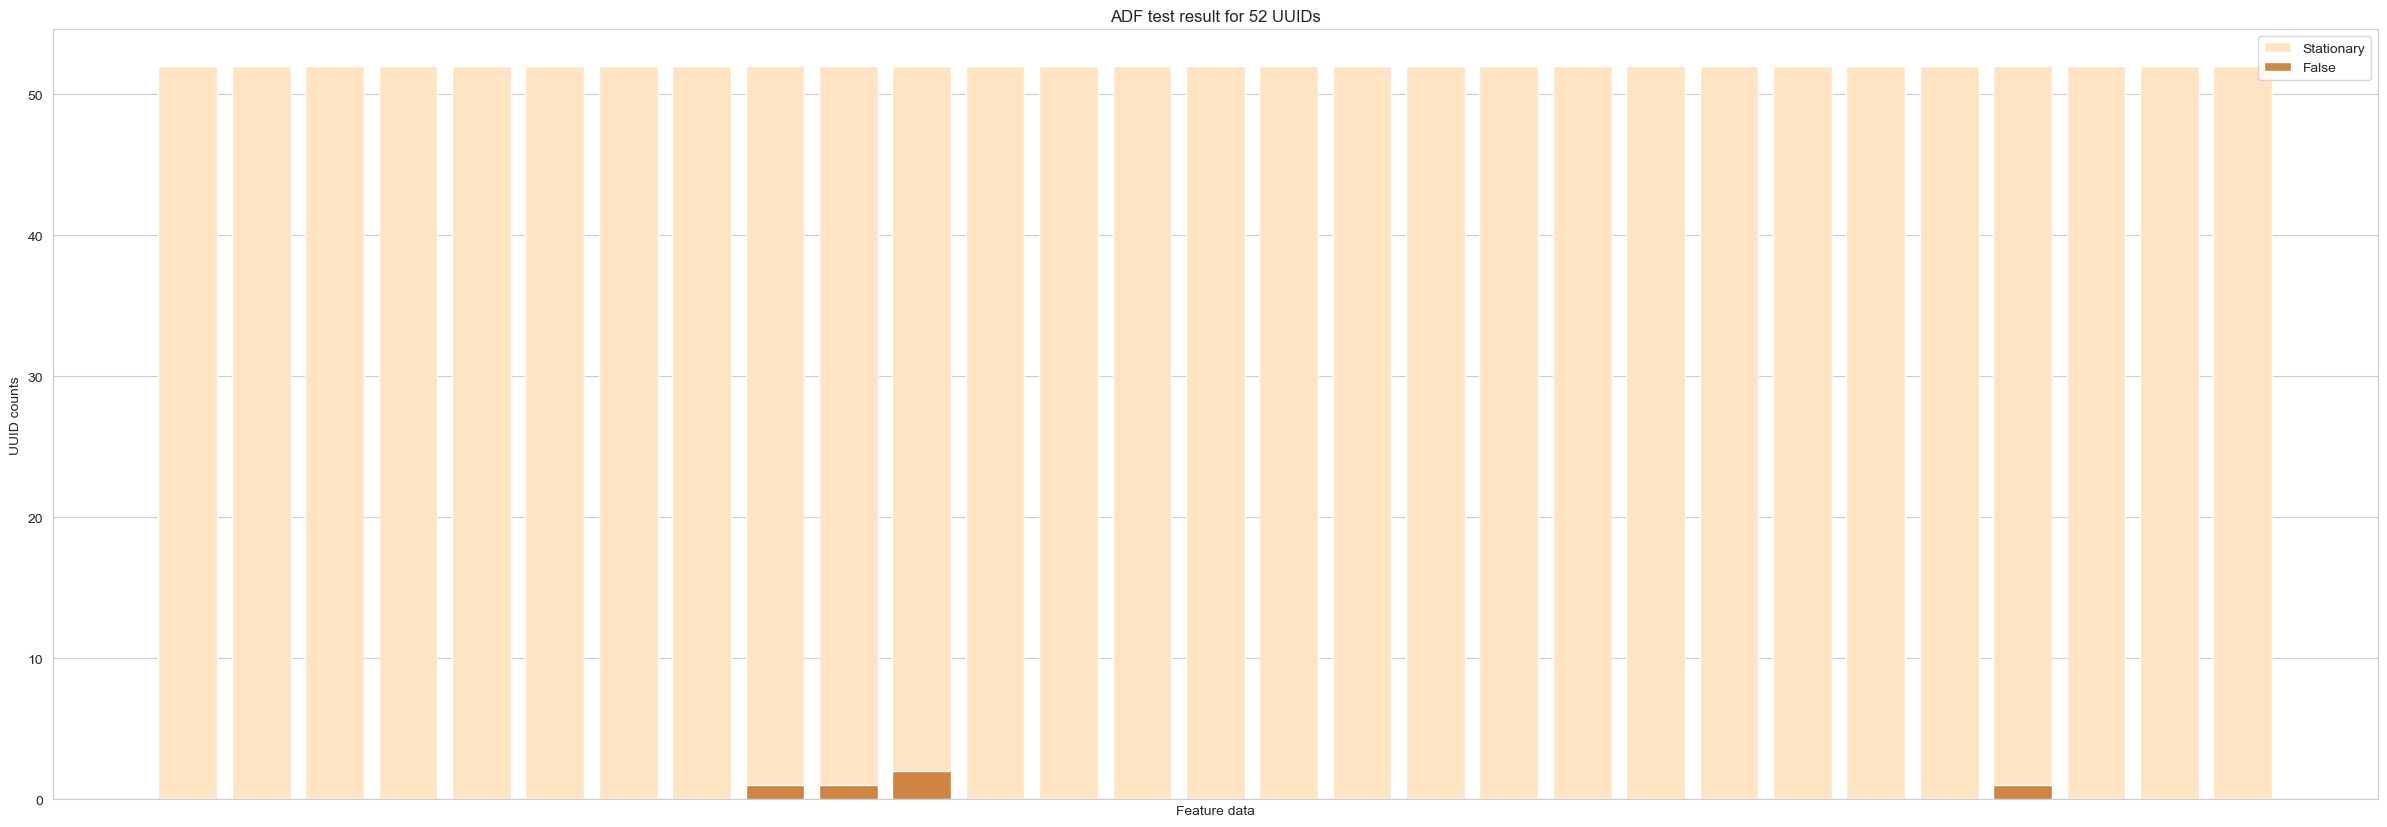

In [23]:
counts = uuid_stationary.apply(pd.Series.value_counts)
counts = counts.fillna(0)
# create bar plot
fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(counts.columns, counts.iloc[1,:]+counts.iloc[0,:],color = 'bisque')
plt.bar(range(len(counts.columns)), counts.iloc[0,:],color = 'peru')

# plt.xticks(range(len(counts.columns)), counts.columns,rotation=90)
plt.xticks([])
plt.title('ADF test result for 52 UUIDs')
plt.legend(['Stationary','False'])
plt.xlabel('Feature data')
plt.ylabel('UUID counts')
plt.show()

### Correlation Analysis for Audio Data
we plot the heat map of correlation matrix with audio data

In [ ]:
with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])
audio_data = feature_data[feature_data.columns[feature_data.columns.str.startswith('audio_naive:')]]
# audio_data['uuid'] = audio_data.index.get_level_values('uuid')
uuid_audio = audio_data.groupby('uuid').count().index
audio_data_uuid = audio_data.loc[uuid_audio[36]]

audio_data_uuid -= np.mean(audio_data_uuid, axis=0)
audio_data_uuid /= np.std(audio_data_uuid, axis = 0)

audio_data_uuid.columns = [i[12:-5] for i in audio_data_uuid.columns]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid') 
g = sns.PairGrid(audio_data_uuid, diag_sharey=False)
g.map_upper(sns.kdeplot,fill = True, bw_adjust = 1)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)

In [ ]:
import seaborn as sns
# audio_data['uuid'] = audio_data.index.get_level_values('uuid')
uuid_audio = audio_data.groupby('uuid').count().index
audio_data_uuid = audio_data.loc[uuid_audio]
audio_data_uuid -= np.mean(audio_data_uuid, axis=0)
audio_data_uuid /= np.std(audio_data_uuid, axis = 0)
audio_data_uuid.columns = [i[12:-5] for i in audio_data_uuid.columns]
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
sns.set(context='notebook', style='ticks', font_scale=2,)
ax = sns.heatmap(audio_data_uuid.corr(), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
# plt.xticks([])
plt.show()

## Model

In [24]:
import lightgbm as lgb
import tensorflow as tf
import keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from sklearn.metrics import *
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier


with gzip.open('cleaned_data.zip','rb') as file:
    feature_data = pd.read_csv(file,index_col=[0,1])

with gzip.open('new_label_data.zip','rb') as file:
    new_label_data = pd.read_csv(file,index_col=[0,1])

Final_data = pd.concat([feature_data,new_label_data],join='inner',ignore_index=False,axis=1)

### eXtreme Gradient Boosting (XGBoost)

In [ ]:
# 80% for training, 10% for validation, 10% for testing
x_train, y_train, x_val, y_val, x_test, y_test = splitdata(Final_data, 0.1)

model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
Y_pred = model.predict(X_test)
predictions = [round(value) for value in Y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("The accuracy of XGBoost: %.2f%%" % (accuracy * 100.0))

### Light Gradient Boosting Machine (LGBM)

In [25]:
# 80% for training, 10% for validation, 10% for testing
x_train, y_train, x_val, y_val, x_test, y_test = splitdata(Final_data, 0.1)

x_train = pd.DataFrame(x_train)
x_val = pd.DataFrame(x_val)
x_test = pd.DataFrame(x_test)

y_train = pd.Series(y_train)
y_val = pd.Series(y_val)
y_test = pd.Series(y_test)

# Build LGBM Model
best_lgbm = lgb.LGBMClassifier(
task= "train",
objective= "multiclass",
metric= "multi_logloss",
verbosity= -1,
boosting_type= "gbdt",
num_class= 7, 
learning_rate= 0.1310183926864668, 
num_leaves= 1680, 
lambda_l1= 1.8343510276558088e-07, 
lambda_l2= 6.066153585423825e-07, 
feature_fraction= 0.8804467412053221, 
bagging_fraction= 0.9809569454316385, 
bagging_freq= 3, 
min_child_samples= 71
)

# Fit LGBM model
best_lgbm.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric= "multi_logloss", early_stopping_rounds=100,)

# Model prediction
y_pred = best_lgbm.predict(x_test)

# Convert labels into easy-to-view form
new_label_dict = {0:'Sleep', 1:'Efficiency', 2:'Exercise', 3:'Life_activity', 4:'Entertainment', 5:'On_the_way', 6:'Normal'}
y_test_pred = [new_label_dict.get(i) for i in y_pred]
y_test_true = [new_label_dict.get(i) for i in y_test]

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.8804467412053221, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8804467412053221
[LightGBM] [Warning] lambda_l1 is set=1.8343510276558088e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8343510276558088e-07
[LightGBM] [Warning] bagging_fraction is set=0.9809569454316385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9809569454316385
[LightGBM] [Warning] lambda_l2 is set=6.066153585423825e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.066153585423825e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[1]	valid_0's multi_logloss: 1.42154
[2]	valid_0's multi_logloss: 1.23453
[3]	valid_0's multi_logloss: 1.09384
[4]	valid_0's multi_logloss: 0.983574
[5]	valid_0's multi_logloss: 0.894478
[6]	valid_0's multi_logloss: 0.822195
[7]	valid_0's multi_logloss: 0.763196
[8]	valid_0's multi_logloss: 0.713617
[9]	valid

#### LightGBM model results
##### Accuracy, Precision, Recall, F1-score

In [26]:
LGBM_acc = accuracy_score(y_test, y_pred)

print("The accuracy of LightGBM model: ", LGBM_acc, "\n")
print(classification_report(y_test_true, y_test_pred))

The accuracy of LightGBM model:  0.9018295403837573 

               precision    recall  f1-score   support

   Efficiency       0.89      0.95      0.92      7594
Entertainment       0.90      0.85      0.87      2662
     Exercise       0.78      0.75      0.77      2156
Life_activity       0.86      0.78      0.82      2154
       Normal       0.88      0.90      0.89      5971
   On_the_way       0.89      0.75      0.81       959
        Sleep       0.98      0.97      0.98      7637

     accuracy                           0.90     29133
    macro avg       0.88      0.85      0.86     29133
 weighted avg       0.90      0.90      0.90     29133



##### Confusion Matrix Plot for LightGBM

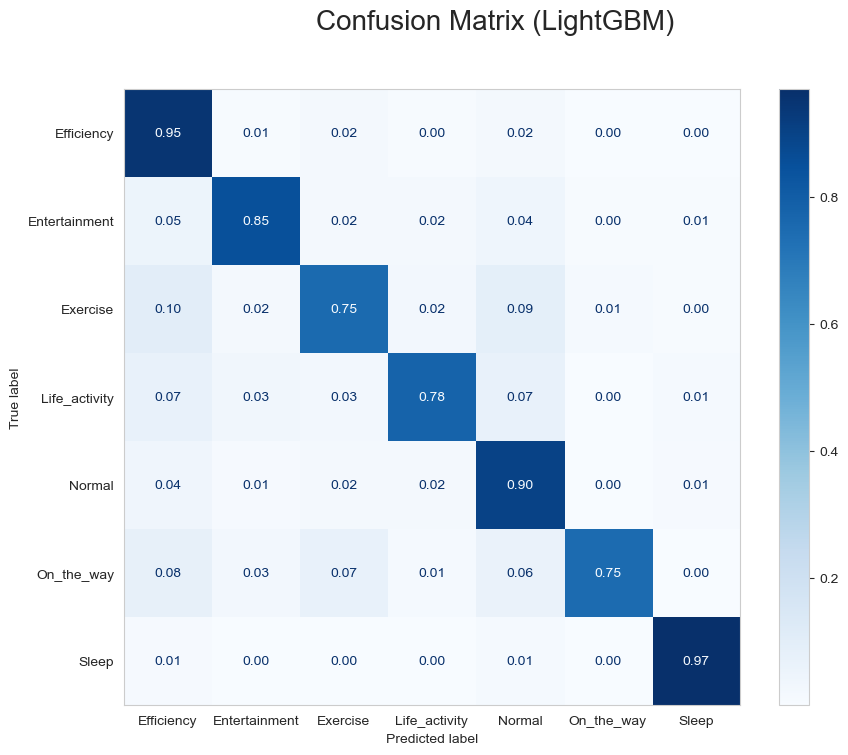

In [27]:
confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap=plt.cm.Blues,normalize='true', values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix (LightGBM)",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(False)
plt.show()

### Artificial Neural Networks (ANN)

In [28]:
# 80% for training, 10% for validation, 10% for testing
x_train, y_train, x_val, y_val, x_test, y_test = splitdata(Final_data, 0.1)

# Define batch size and output classes
batch_size = int(len(x_train) // 10000)
classes = 7

# Build ANN model
def Build_NN():
    model = Sequential()
    
    # Hidden layer 1
    model.add(Dense(1300, activation='relu'))
    model.add(Dropout(rate=0.16841380557977734))
    
    # Hidden layer 2
    model.add(Dense(2000, activation='relu'))
    model.add(Dropout(rate=0.12075541721671049))
    
    # Hidden layer 3
    model.add(Dense(1450, activation='relu'))
    model.add(Dropout(rate=0.21586172555968303))
    
    # Output layer
    model.add(Dense(classes, activation="softmax"))
    
    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = tf.optimizers.Adam(learning_rate = 0.00015164741842153617),
        metrics = ["accuracy"],)
    
    return model

Best_NNmodel = Build_NN()


# Fit ANN model
Best_NN = Best_NNmodel.fit(
    x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=30
)


# Model prediction
y_pred = Best_NNmodel.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert labels into easy-to-view form
y_test_pred = [new_label_dict.get(i) for i in y_pred]
y_test_true = [new_label_dict.get(i) for i in y_test]

Epoch 1/30
10139/10139 [==============================] - 49s 5ms/step - loss: 2.0193 - accuracy: 0.3626 - val_loss: 1.4852 - val_accuracy: 0.4565
Epoch 2/30
10139/10139 [==============================] - 47s 5ms/step - loss: 1.4285 - accuracy: 0.4802 - val_loss: 1.2467 - val_accuracy: 0.5418
Epoch 3/30
10139/10139 [==============================] - 47s 5ms/step - loss: 1.2372 - accuracy: 0.5501 - val_loss: 1.1066 - val_accuracy: 0.6012
Epoch 4/30
10139/10139 [==============================] - 47s 5ms/step - loss: 1.1235 - accuracy: 0.5927 - val_loss: 1.0533 - val_accuracy: 0.6139
Epoch 5/30
10139/10139 [==============================] - 47s 5ms/step - loss: 1.0498 - accuracy: 0.6182 - val_loss: 0.9503 - val_accuracy: 0.6515
Epoch 6/30
10139/10139 [==============================] - 47s 5ms/step - loss: 0.9974 - accuracy: 0.6357 - val_loss: 0.9078 - val_accuracy: 0.6649
Epoch 7/30
10139/10139 [==============================] - 47s 5ms/step - loss: 0.9581 - accuracy: 0.6509 - val_loss: 0

#### ANN model training process

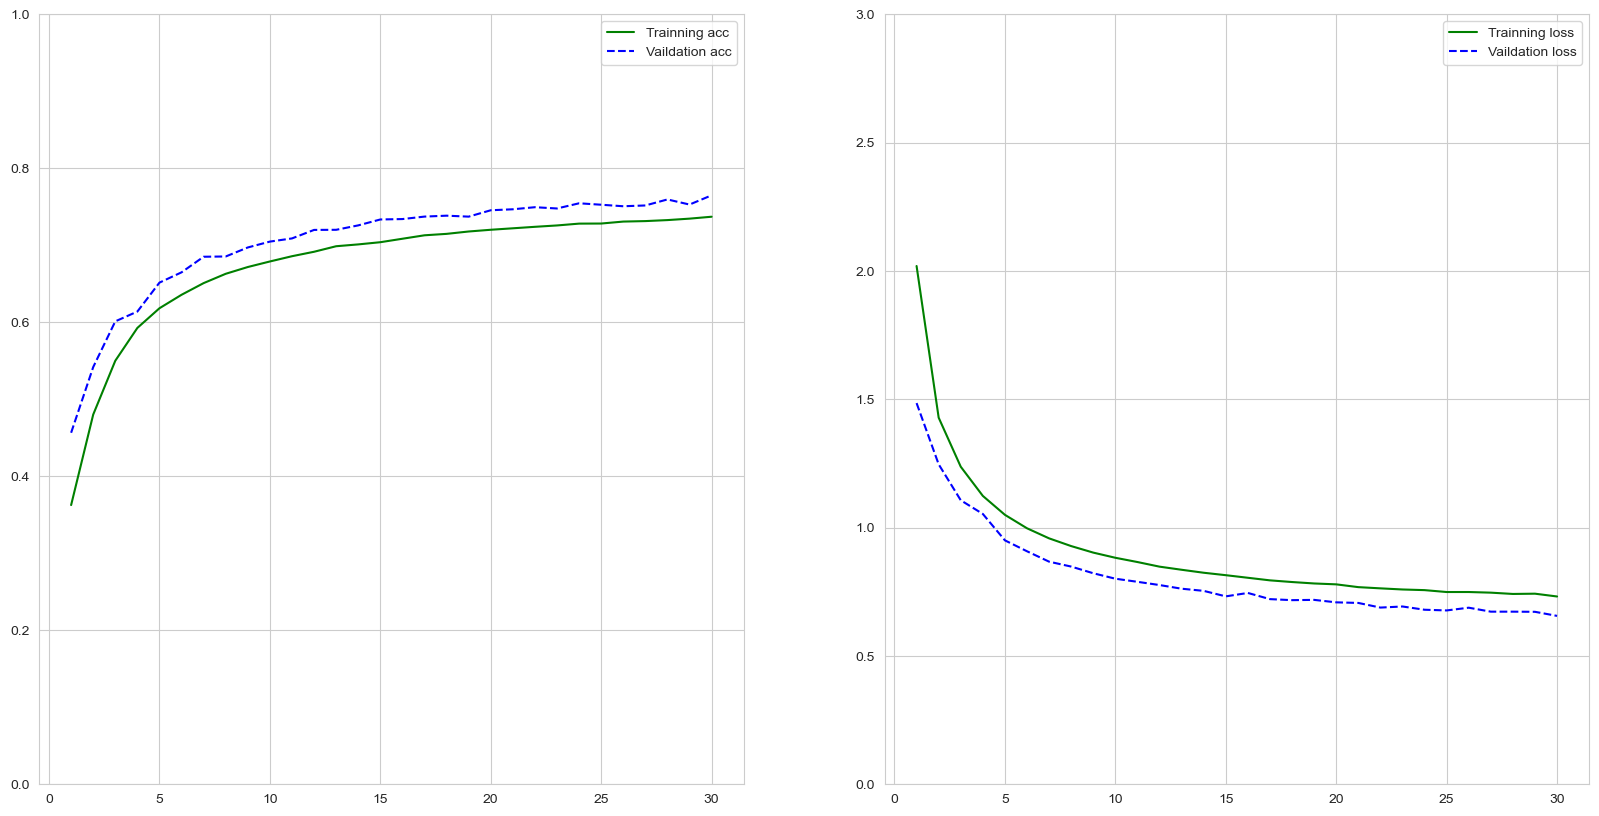

In [29]:
acc = Best_NN.history['accuracy']     #获取训练集准确性数据
val_acc = Best_NN.history['val_accuracy']    #获取验证集准确性数据
loss = Best_NN.history['loss']          #获取训练集错误值数据
val_loss = Best_NN.history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,3)
plt.show()

#### ANN model results
##### Accuracy, Precision, Recall, F1-score

In [30]:
ANN_acc = accuracy_score(y_test_true, y_test_pred)

print("The accuracy of ANN model: ", ANN_acc, "\n")
print(classification_report(y_test_true, y_test_pred))

The accuracy of ANN model:  0.7706381079875055 

               precision    recall  f1-score   support

   Efficiency       0.72      0.87      0.79      7594
Entertainment       0.71      0.64      0.67      2662
     Exercise       0.64      0.62      0.63      2156
Life_activity       0.69      0.39      0.50      2154
       Normal       0.74      0.72      0.73      5971
   On_the_way       0.75      0.56      0.64       959
        Sleep       0.92      0.93      0.93      7637

     accuracy                           0.77     29133
    macro avg       0.74      0.68      0.70     29133
 weighted avg       0.77      0.77      0.76     29133



##### Confusion Matrix Plot for ANN

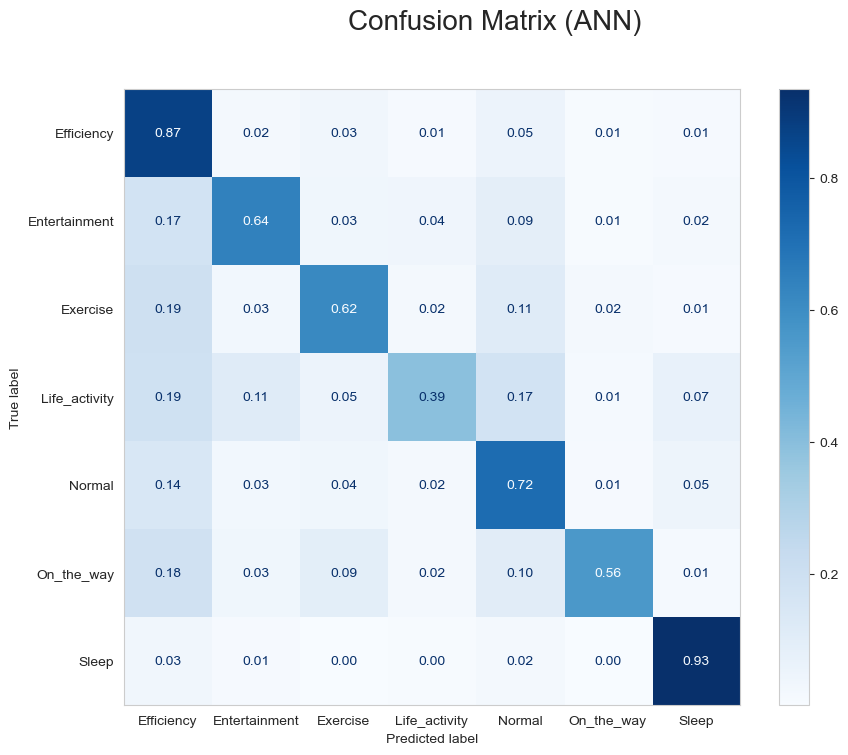

In [31]:
confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix (ANN)",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(False)
plt.show()

### Long Short-Term Memory (LSTM)

In [32]:
# We use 3 past minutes as features and we want to forecast 1 step ahead:
x_train, y_train, x_val, y_val, x_test, y_test  = TS_split(Final_data, n_past=3, n_pred=1)


print("Detailed shape of the datasets for the LSTM model")
print(f"Shape of training X: {x_train.shape}")
print(f"Shape of training Y: {y_train.shape}")

print(f"Shape of validation X: {x_val.shape}")
print(f"Shape of validation Y: {y_val.shape}")

print(f"Shape of testing X: {x_test.shape}")
print(f"Shape of testing Y: {y_test.shape}")

# Define timesteps, features, outputs classes
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]
n_outputs = 7

# Define batch size, epochs
batch_size = int(len(x_train) // 10000)
epochs=10

Detailed shape of the datasets for the LSTM model
Shape of training X: (221016, 3, 51)
Shape of training Y: (221016, 1)
Shape of validation X: (36311, 3, 51)
Shape of validation Y: (36311, 1)
Shape of testing X: (34216, 3, 51)
Shape of testing Y: (34216, 1)


In [33]:
# Build LSTM model
def Build_LSTM():
    lstm_layer = keras.layers.LSTM(100, input_shape=(n_timesteps, n_features))
    model = keras.models.Sequential(
    [
        lstm_layer,
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(45, activation='relu'),
        keras.layers.Dropout(0.2990628539770123),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(72, activation='relu'),
        keras.layers.Dropout(0.4864208063056207),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(153, activation='relu'),
        keras.layers.Dropout(0.39279029213912864),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(244, activation='relu'),
        keras.layers.Dropout(0.31946249134351457),
        keras.layers.BatchNormalization(),
        
        keras.layers.Dense(n_outputs, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(6.331604373902864e-06)),
    ])
    return model


Best_LSTMmodel = Build_LSTM()
Best_LSTMmodel.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.00015164741842153617),
    metrics=["accuracy"],
)


# Fit LSTM model
Best_LSTM = Best_LSTMmodel.fit(
    x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=10
)


# Model prediction
y_pred = Best_LSTMmodel.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert labels into easy-to-view form
y_test_pred = [new_label_dict.get(i) for i in y_pred]
y_test_true = [new_label_dict.get(int(i[0])) for i in y_test]

Epoch 1/10
10047/10047 [==============================] - 167s 16ms/step - loss: 1.8162 - accuracy: 0.3072 - val_loss: 1.7262 - val_accuracy: 0.3160
Epoch 2/10
10047/10047 [==============================] - 168s 17ms/step - loss: 1.5833 - accuracy: 0.4130 - val_loss: 1.7570 - val_accuracy: 0.3244
Epoch 3/10
10047/10047 [==============================] - 181s 18ms/step - loss: 1.4977 - accuracy: 0.4513 - val_loss: 1.7968 - val_accuracy: 0.3052
Epoch 4/10
10047/10047 [==============================] - 175s 17ms/step - loss: 1.4266 - accuracy: 0.4808 - val_loss: 1.7195 - val_accuracy: 0.3707
Epoch 5/10
10047/10047 [==============================] - 174s 17ms/step - loss: 1.2109 - accuracy: 0.5670 - val_loss: 0.9466 - val_accuracy: 0.6231
Epoch 6/10
10047/10047 [==============================] - 162s 16ms/step - loss: 0.7961 - accuracy: 0.7157 - val_loss: 0.6011 - val_accuracy: 0.7862
Epoch 7/10
10047/10047 [==============================] - 167s 17ms/step - loss: 0.5972 - accuracy: 0.8002

#### LSTM model training process

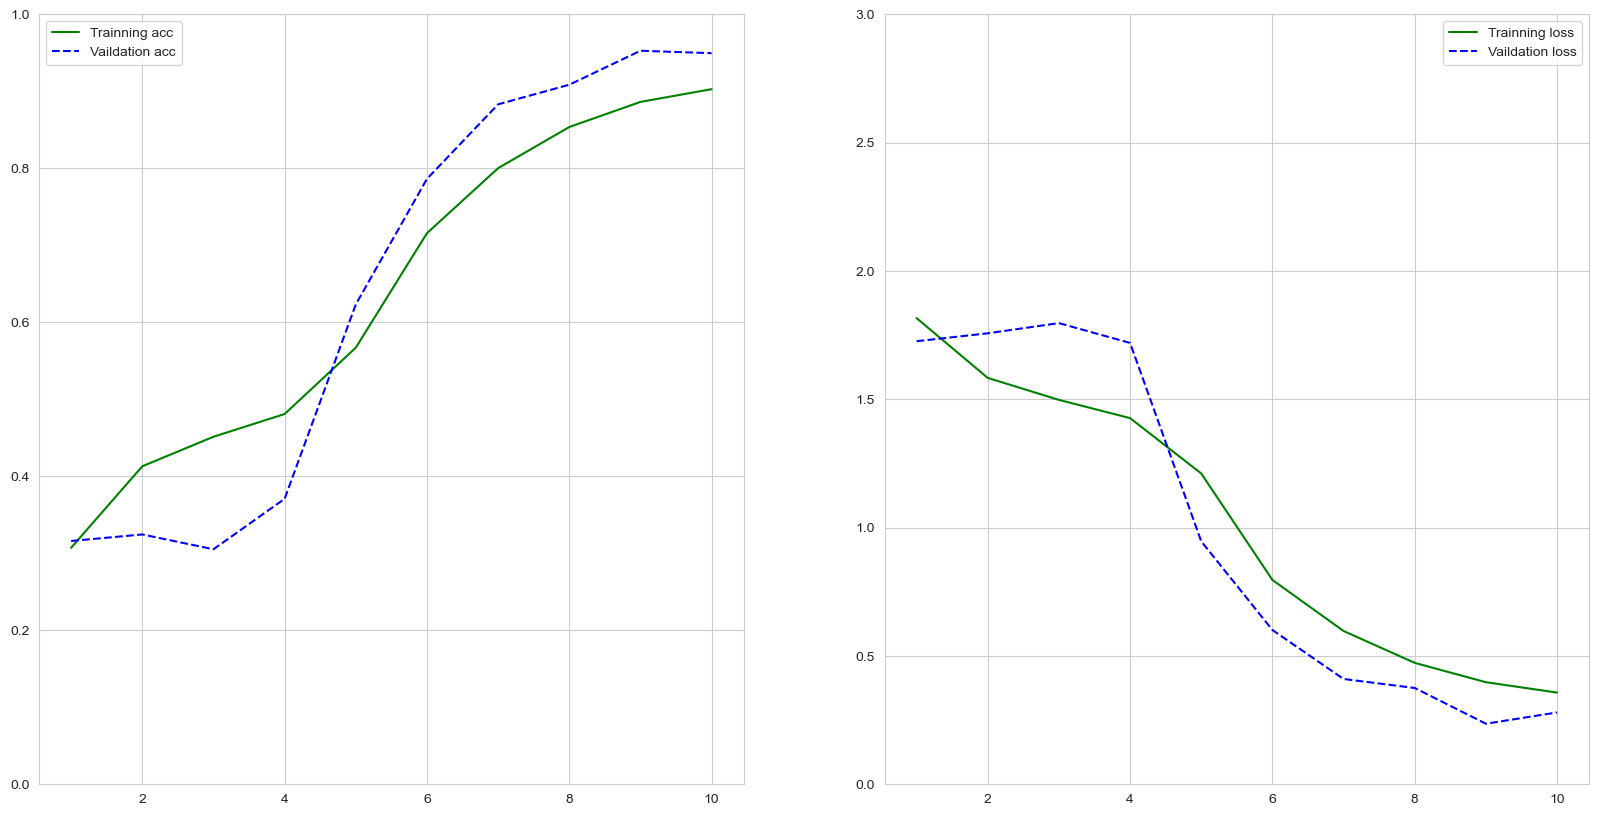

In [34]:
acc = Best_LSTM.history['accuracy']     #获取训练集准确性数据
val_acc = Best_LSTM.history['val_accuracy']    #获取验证集准确性数据
loss = Best_LSTM.history['loss']          #获取训练集错误值数据
val_loss = Best_LSTM.history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
plt.ylim(0,3)
plt.show()

#### LSTM model results
##### Accuracy, Precision, Recall, F1-score

In [35]:
LSTM_acc = accuracy_score(y_test_true, y_test_pred)

print("The accuracy of LSTM model: ", LSTM_acc, "\n")
print(classification_report(y_test_true, y_test_pred))

The accuracy of LSTM model:  0.9682312368482581 

               precision    recall  f1-score   support

   Efficiency       0.99      0.99      0.99      7937
Entertainment       0.97      0.96      0.97      4093
     Exercise       0.89      0.92      0.90      2194
Life_activity       0.95      0.94      0.94      2834
       Normal       0.95      0.98      0.97      8012
   On_the_way       0.94      0.73      0.82      1197
        Sleep       0.99      1.00      1.00      7949

     accuracy                           0.97     34216
    macro avg       0.96      0.93      0.94     34216
 weighted avg       0.97      0.97      0.97     34216



##### Confusion Matrix Plot for LSTM

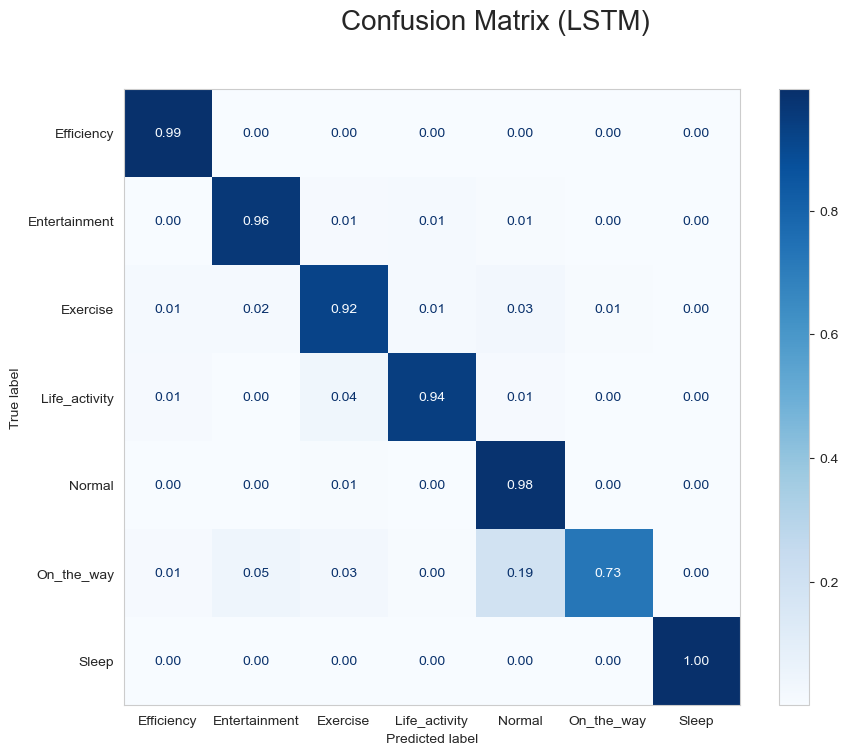

In [36]:
confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix (LSTM)",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(False)
plt.show()

### Gated Recurrent Unit (GRU)

In [ ]:
# We use 3 past minutes as features and we want to forecast 1 step ahead:
x_train, y_train, x_val, y_val, x_test, y_test  = TS_split(Final_data, n_past=3, n_pred=1)


print("Detailed shape of the datasets for the GRU model")
print(f"Shape of training X: {x_train.shape}")
print(f"Shape of training Y: {y_train.shape}")

print(f"Shape of validation X: {x_val.shape}")
print(f"Shape of validation Y: {y_val.shape}")

print(f"Shape of testing X: {x_test.shape}")
print(f"Shape of testing Y: {y_test.shape}")

# Define timesteps, features, outputs classes
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]
n_outputs = 7

# Define batch size, epochs, units
batch_size = int(len(x_train) // 10000)
epochs=10
units = 256

In [ ]:
# Build GRU model
def Build_GRU():
    gru_layer = keras.layers.GRU(units, input_shape=(n_timesteps,n_features))
    model = keras.models.Sequential(
        [
            gru_layer,
            keras.layers.Dropout(0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

Best_GRUmodel = Build_GRU()
Best_GRUmodel.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer="Adamax",
    metrics=["accuracy"],
)


# Fit GRU model
Best_GRU = Best_GRUmodel.fit(
    x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=10
)


# Model prediction
y_pred = Best_GRUmodel.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Convert labels into easy-to-view form
y_test_pred = [new_label_dict.get(i) for i in y_pred]
y_test_true = [new_label_dict.get(int(i[0])) for i in y_test]

#### GRU model training process

In [ ]:
acc = Best_GRU.history['accuracy']     #获取训练集准确性数据
val_acc = Best_GRU.history['val_accuracy']    #获取验证集准确性数据
loss = Best_GRU.history['loss']          #获取训练集错误值数据
val_loss = Best_GRU.history['val_loss']  #获取验证集错误值数据

epochs = range(1,len(acc)+1)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.plot(epochs,acc,'g',label='Trainning acc')     #以epochs为横坐标，以训练集准确性为纵坐标
ax1.plot(epochs,val_acc,'b--',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
ax1.legend()   #绘制图例，即标明图中的线段代表何种含义
ax1.set_title('Accuracy in each epoch',fontsize=20)
plt.ylim(0,1)
ax2 = fig.add_subplot(122)
ax2.plot(epochs,loss,'g',label='Trainning loss')
ax2.plot(epochs,val_loss,'b--',label='Vaildation loss')
ax2.legend()  ##绘制图例，即标明图中的线段代表何种含义
ax2.set_title('Loss in each epoch',fontsize=20)
plt.ylim(0,3)
plt.show()

#### GRU model results
##### Accuracy, Precision, Recall, F1-score

In [ ]:
GRU_acc = accuracy_score(y_test_true, y_test_pred)

print("The accuracy of GRU model: ", GRU_acc, "\n")
print(classification_report(y_test_true, y_test_pred))

##### Confusion Matrix Plot for GRU

In [ ]:
confusion = metrics.ConfusionMatrixDisplay.from_predictions(y_test_true,y_test_pred,cmap='Blues',normalize='true',values_format='.2f')
confusion.figure_.suptitle("Confusion Matrix (GRU)",fontsize=20)
confusion.figure_.set_size_inches(10,8)
plt.grid(False)
plt.show()